# Detecting Acute Respiratory Distress in NHS 111 Calls

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#modelling">Predictive Modelling</a></li>
<li><a href="#conclusions">Conclusions & Next Steps</a></li>
</ul>

<a id='intro'></a>
## Introduction

This notebook performs data analysis and modelling using a (private) dataset containing information on 74 calls made to NHS 111, with callers labelled as being in acute respiratory distress (ARD, 40) or not (non-ARD, 34).

For privacy reasons, the content and metadata of the conversations were completely removed:
- No audio
- No transcription
- No time of day or location
- No caller identity data

The dataset consists of 74 CSV files, each containing a subset of the IBM Watson STT JSON response. Each row in the CSV corresponds to one word in the call, and there are five features per word:

1. **TimeFrom:** Beginning time for the word
2. **TimeTo:** End time for the word
3. **Speaker:** Who is saying the word (0: operator, 1: caller)
4. **Gap between:** A derived feature: the pause between the previous speaker finishing and the current speaker starting. 
5. **Confidence:** IBM's confidence that the transcription it gave to the word is correct (a probability)

The question, therefore, is as follows: *To what extent, with this limited dataset, is it possible to classify callers as being in ARD or not?*

The motivation for asking this question is to enable NHS 111 to automatically prioritise individuals in ARD so that their waiting times are minimised.

In [122]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis

# Model selection & pipelining 
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve

sns.set_theme()
%matplotlib inline

### Helper functions

In [123]:
# Calculates number of turns in the conversation for both speakers

def calc_num_turns(arr):
    num_operator = 0
    num_caller = 0
    curr = -1
    
    for i in arr:
        if i != curr:
            curr = i
            if i == 0:
                num_operator += 1
            else: 
                num_caller += 1
                
    return [num_operator, num_caller]

In [124]:
# Calculates the kurtosis of turn length for both speakers

def calc_turn_kurtosis(df):
    operator_turn_lens = []
    caller_turn_lens = []
    curr = 0
    time_from = 0
    
    for i in range(df.shape[0]):
        if i == (df.shape[0] - 1):
            if curr == 0:
                operator_turn_lens.append(df['TimeTo'][i] - time_from)
            else: 
                caller_turn_lens.append(df['TimeTo'][i] - time_from)
        elif df['Speaker'][i + 1] != curr:
            if curr == 0:
                operator_turn_lens.append(df['TimeTo'][i] - time_from)
            else: 
                caller_turn_lens.append(df['TimeTo'][i] - time_from)
            curr = df['Speaker'][i + 1]
            time_from = df['TimeFrom'][i + 1]
            
    return [kurtosis(np.array(operator_turn_lens)), kurtosis(np.array(caller_turn_lens))]

In [125]:
# Generic bar chart plotting

def plot_bar_chart(axis, xlabels, metrics, ylabel):
    accuracy = pd.DataFrame(data=metrics, columns=[ylabel], index=xlabels)
    ax = sns.barplot(ax=axis, x=xlabels, y=ylabel, data=accuracy)
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points');

In [126]:
# Feature analysis plotting

def plot_feature_analysis(title, colour, non_ARD_avg, ARD_avg):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
    fig.suptitle(title, fontweight='bold')
    
    # Scatter plot
    df.plot.scatter(ax=ax1, x=title, y='in_ARD', c=colour)
    
    # Bar chart 
    plot_bar_chart(ax2, xlabels=['Not in ARD', 'In ARD'], metrics=np.array([non_ARD_avg, ARD_avg]), ylabel='Averages');

In [127]:
# Confusion matrix plotting 

def plot_conf_matrix(axis, conf_matrix):
    sns.heatmap(conf_matrix, ax=axis, annot=True, cmap="YlGnBu", fmt='g')    
    axis.set_ylabel('Actual label')
    axis.set_xlabel('Predicted label')
    axis.set_title('Confusion Matrix');

In [128]:
# Specificity vs. sensitivity plotting 

def plot_spec_sens(y_probs, spec, sens, title):
    fpr, tpr, _ = roc_curve(y, y_probs)
    fig, axis = plt.subplots(figsize=(7,7))
    axis.plot(1 - fpr, tpr)
    plt.scatter(spec, sens, color='red', alpha=1, zorder=3)
    axis.set_xlabel('Specificity (TNR)')
    axis.set_ylabel('Sensitivity (TPR)')
    plt.title(title, fontweight='bold');

<a id='wrangling'></a>
## Data Wrangling

### Loading files

In [129]:
# Set relative path to non_ARD and ARD dir

non_ARD_dir = 'dummy_data/non_ARD'
ARD_dir = 'dummy_data/ARD'

In [130]:
from os import listdir

non_ARD_files = [f'dummy_data/non_ARD/{f}' for f in listdir(non_ARD_dir)]
ARD_files = [f'dummy_data/ARD/{f}' for f in listdir(ARD_dir)]

files = {
    0: non_ARD_files,
    1: ARD_files
}

In [131]:
# Preview one file

df_preview = pd.read_csv(ARD_files[0], delimiter=',')
df_preview.head()

,TimeFrom,TimeTo,Speaker,Gap between speakers,Confidence
0,0.00,0.62,1,0.0,0.49
1,0.65,0.82,1,0.0,0.67
2,0.82,0.91,1,0.0,0.67
3,0.91,1.11,1,0.0,0.67
4,1.11,1.22,1,0.0,0.67


### Creating features from raw data

Four features were identified as being of interest for the caller:

- **Words per minute:** Individuals in ARD might speak more slowly (although they could also be panicking and speaking more quickly).
- **Words per turn:** Individuals in ARD might be able to say fewer words per turn.
- **% of conversation speaking:** Individuals in ARD might say less overall in the conversation.
- **Kurtosis of turn length:** Kurtosis is a measure of a distribution's 'tailedness', or the propensity for the distribution to produce outliers. Individuals in ARD, given the limitations this places on their speaking, might have a lower kurtosis of turn length due to the physical limitations they are experiencing.

These were also calculated for the operator, since it might be that we need to account for these when looking at caller features. For example, individuals have a tendency to mirror others, so if the operator naturally speaks more quickly then we might observe callers (on average) speaking more quickly with that operator too.

Such 'operator' features were not analysed here, however, both for brevity and to avoid the *curse of dimensionality* (we should avoid having too many features with only 74 data points). This is left as an avenue for future work. 

In [132]:
dataset = []

# For each output class (0 = non-ARD, 1 = ARD)
for output_class in [0, 1]:
    for path in files[output_class]:
        
        df = pd.read_csv(path, delimiter=',')
        
        row = []
                
        ## RAW DF WRANGLING
        # Fix speaker mislabelling (e.g. 1 and 2 instead of 0 and 1)
        if df['Speaker'].isin([1, 2]).all():
            df['Speaker'] = df['Speaker'] - 1
        elif df['Speaker'].isin([0, 2]).all():
            df.loc[df['Speaker'] == 2, 'Speaker'] = 1
            
        # Add derived column
        df['duration'] = df['TimeTo'] - df['TimeFrom']
        
        
        # Helper masks
        operator_mask = df['Speaker'] == 0
        caller_mask = df['Speaker'] == 1
        
        
        ## 1) WORDS PER MINUTE
        operator_words = df[operator_mask].shape[0]
        operator_duration = df[operator_mask]['duration'].sum()
        operator_wp_min = operator_words / operator_duration * 60
        row.append(operator_wp_min)
        
        caller_words = df[caller_mask].shape[0]
        caller_duration = df[caller_mask]['duration'].sum()
        caller_wp_min = caller_words / caller_duration * 60
        row.append(caller_wp_min)
        
        
        ## 2) WORDS PER TURN
        operator_turns, caller_turns = calc_num_turns(df['Speaker'])
        operator_wp_turn = operator_words / operator_turns
        row.append(operator_wp_turn)
        caller_wp_turn = caller_words / caller_turns
        row.append(caller_wp_turn)
        
        
        ## 3) % CONVERSATION DURATION
        operator_percent = operator_duration / (caller_duration + operator_duration)
        row.append(operator_percent)
        caller_percent = 1 - operator_percent
        row.append(caller_percent)
        
        
        ## 4) KURTOSIS TURN LENGTH
        operator_len_kurt, caller_len_kurt = calc_turn_kurtosis(df)
        row.append(operator_len_kurt)
        row.append(caller_len_kurt)
        
        # Output label
        row.append(output_class)
        
        dataset.append(row)
        

In [133]:
# Convert dataset to DataFrame & preview

columns = [
    'operator_wp_min', 
    'caller_wp_min',
    'operator_wp_turn', 
    'caller_wp_turn',
    'operator_percent',
    'caller_percent',
    'operator_turn_kurt',
    'caller_turn_kurt',
    'in_ARD'
]

df = pd.DataFrame(dataset, columns=columns)
df.head()

,operator_wp_min,caller_wp_min,operator_wp_turn,caller_wp_turn,operator_percent,caller_percent,operator_turn_kurt,caller_turn_kurt,in_ARD
0,228.029242,192.445820,17.878049,6.317073,0.704883,0.295117,4.073135,12.685567,0
1,232.144276,182.647601,12.815789,9.131579,0.524764,0.475236,3.454322,8.030907,0
2,217.118595,232.330827,41.666667,12.875000,0.795746,0.204254,0.942607,-1.064707,0
3,233.180794,195.127557,13.547619,6.738095,0.627212,0.372788,4.345672,7.257747,0
4,218.520756,179.834134,17.583333,8.956522,0.627681,0.372319,1.798440,6.767570,0


<a id='eda'></a>
## Exploratory Data Analysis

### Summary statistics

In [134]:
# Count nulls and duplicates

num_nulls = len(df.index) - len(df.dropna().index)
num_duplicates = sum(df.duplicated())

print('Num. nulls:\t', num_nulls)
print('Num. duplicates:', num_duplicates)

Num. nulls:	 0
Num. duplicates: 0


In [135]:
# Drop operator features (not used in this analysis, as discussed previously)

df.drop(['operator_wp_min', 'operator_wp_turn', 'operator_percent', 'operator_turn_kurt'], axis=1, inplace=True)
df.describe()

,caller_wp_min,caller_wp_turn,caller_percent,caller_turn_kurt,in_ARD
count,74.000000,74.000000,74.000000,74.000000,74.000000
mean,201.213950,8.205312,0.394206,8.004148,0.540541
std,21.172603,3.853361,0.113929,7.207496,0.501756
min,154.838710,2.844444,0.204254,-1.500000,0.000000
25%,187.096680,6.049291,0.318129,2.531612,0.000000
50%,200.514116,7.287356,0.362504,6.224098,1.000000
75%,213.339148,9.212243,0.444907,12.154385,1.000000
max,277.842324,22.250000,0.788993,27.385155,1.000000


In [136]:
# Number of unique values

df.nunique()

caller_wp_min       74
caller_wp_turn      74
caller_percent      74
caller_turn_kurt    74
in_ARD               2
dtype: int64

### Relationships between features

The correlations between many of the features below suggest that *Naive Bayes* should not be used, since its conditional independence assumption would be violated.

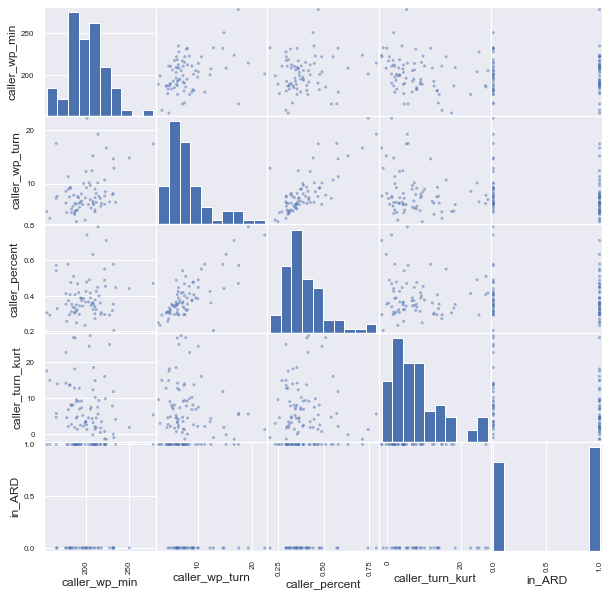

In [137]:
# Overall summary of relationships between variables

pd.plotting.scatter_matrix(df, figsize=(10, 10));

### Investigating feature relevance

- **caller_wp_min**: Appears to be irrelevant. Callers' baseline (when not in ARD) speaking rates would potentially be needed here, since different people naturally have different speaking rates.  
- **caller_wp_turn**: Appears to be highly relevant
- **caller_percent**: Appears to be relevant, but in a non-linear fashion: non-ARD callers are less likely to have extreme values
- **caller_turn_kurt**: Appears to be highly relevant

In [138]:
# Helper mask
ARD_mask = df['in_ARD'] == 1

# caller_wp_min
non_ARD_wp_min = df[~ARD_mask]['caller_wp_min'].mean()
ARD_wp_min = df[ARD_mask]['caller_wp_min'].mean()

# caller_wp_turn
non_ARD_wp_turn = df[~ARD_mask]['caller_wp_turn'].mean()
ARD_wp_turn = df[ARD_mask]['caller_wp_turn'].mean()

# caller_percent
non_ARD_percent = df[~ARD_mask]['caller_percent'].mean()
ARD_percent = df[ARD_mask]['caller_percent'].mean()

# caller_turn_kurt
non_ARD_turn_kurt = df[~ARD_mask]['caller_turn_kurt'].mean()
ARD_turn_kurt = df[ARD_mask]['caller_turn_kurt'].mean()

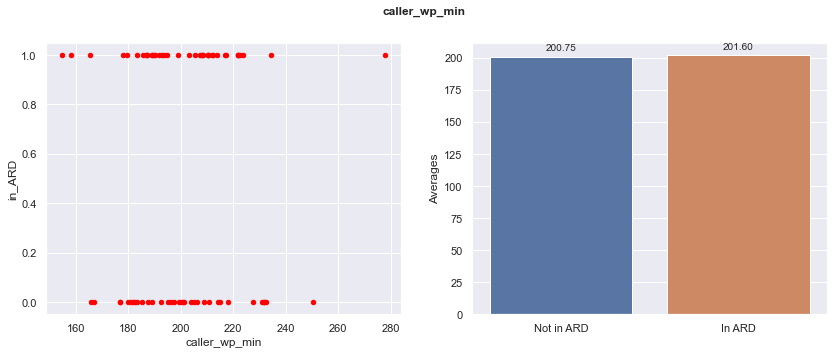

In [139]:
# caller_wp_min analysis

plot_feature_analysis('caller_wp_min', 'red', non_ARD_wp_min, ARD_wp_min)

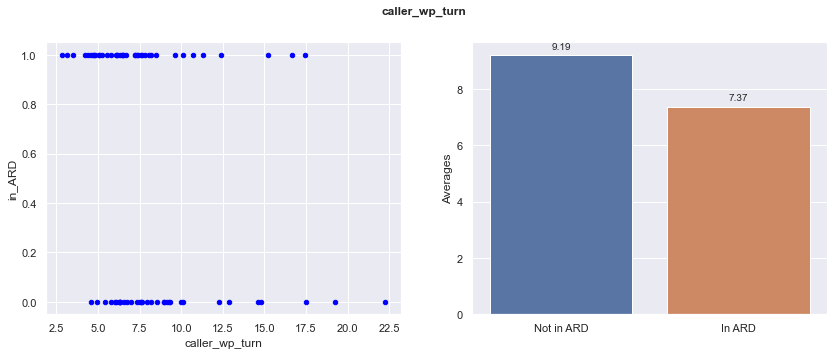

In [140]:
# caller_wp_turn analysis

plot_feature_analysis('caller_wp_turn', 'blue', non_ARD_wp_turn, ARD_wp_turn)

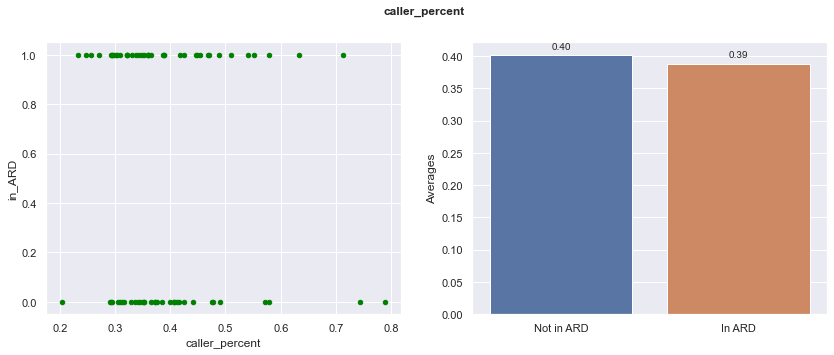

In [141]:
# caller_percent analysis

plot_feature_analysis('caller_percent', 'green', non_ARD_percent, ARD_percent)

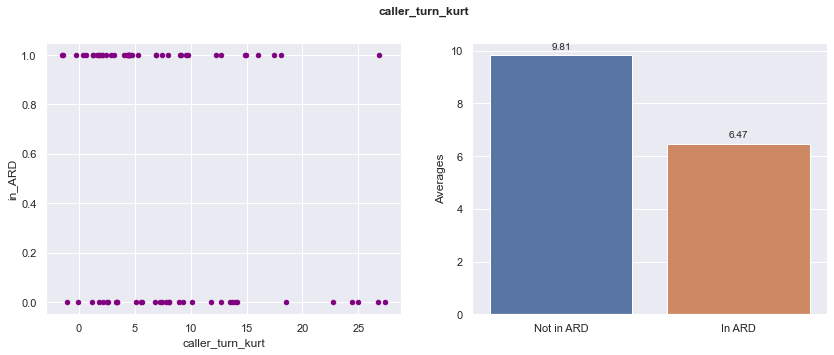

In [142]:
# caller_turn_kurt analysis

plot_feature_analysis('caller_turn_kurt', 'purple', non_ARD_turn_kurt, ARD_turn_kurt)

In [143]:
# Drop caller_wp_min since it appears to be irrelevant

df.drop(['caller_wp_min'], axis=1, inplace=True)
df.head()

,caller_wp_turn,caller_percent,caller_turn_kurt,in_ARD
0,6.317073,0.295117,12.685567,0
1,9.131579,0.475236,8.030907,0
2,12.875000,0.204254,-1.064707,0
3,6.738095,0.372788,7.257747,0
4,8.956522,0.372319,6.767570,0


<a id='modelling'></a>
## Predictive Modelling

### Model scoring

The following algorithms were fit to the data:

- Logistic Regression
- K-Nearest Neighbours (KNN)
- Support Vector Machine
- Decision Tree
- XGBoost

Nested cross-validation was employed to both enable hyperparameter tuning and to increase confidence in estimates of test set performance (due to the limited data available). 

Models were scored according to their accuracy (% of predictions correct), since this metric is applicable to all of the algorithms (other metrics, such as AUC, are not). 

In [144]:
# Create design and output matrices
X = df.iloc[:,:-1]
y = df.iloc[:,-1:]

# Cross-validation techniques
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=44)
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=44)

In [145]:
# Logistic Regression

lr = LogisticRegression()
lr_pipe = make_pipeline(StandardScaler(), lr)

param_grid = {
    'logisticregression__C': np.logspace(-4, 4, 8)
}

clf = GridSearchCV(lr_pipe, param_grid, cv=inner_cv)
accuracies = cross_val_score(clf, X, y.values.ravel(), cv=outer_cv)

lr_score = accuracies.mean()

# Additional statistics
lr_pred = cross_val_predict(clf, X, y.values.ravel(), cv=outer_cv)
lr_pred_prob = cross_val_predict(clf, X, y.values.ravel(), cv=outer_cv, method='predict_proba')

In [146]:
# KNN

neigh = KNeighborsClassifier()
neigh_pipe = make_pipeline(StandardScaler(), neigh)

param_grid = {
    'kneighborsclassifier__n_neighbors': range(1, 10, 1)
}

clf = GridSearchCV(neigh_pipe, param_grid, cv=inner_cv)
accuracies = cross_val_score(clf, X, y.values.ravel(), cv=outer_cv)

neigh_score = accuracies.mean()

In [147]:
# Support Vector Machine

svc = SVC()
svc_pipe = make_pipeline(StandardScaler(), svc)

param_grid = [
  {'svc__C': [0.01, 0.1, 1, 10, 100], 'svc__kernel': ['linear']},
  {'svc__C': [0.01, 0.1, 1, 10, 100], 'svc__gamma': [0.001, 0.01, 0.1, 1], 'svc__kernel': ['rbf']}
]

clf = GridSearchCV(svc_pipe, param_grid, cv=inner_cv)
accuracies = cross_val_score(clf, X, y.values.ravel(), cv=outer_cv)

svc_score = accuracies.mean()

In [148]:
# Decision Tree

dt = DecisionTreeClassifier()
dt_pipe = make_pipeline(StandardScaler(), dt)

param_grid = {
    'decisiontreeclassifier__max_depth': range(3, 16, 2),
    'decisiontreeclassifier__criterion': ['gini', 'entropy']
}

clf = GridSearchCV(dt_pipe, param_grid, cv=inner_cv)
accuracies = cross_val_score(clf, X, y.values.ravel(), cv=outer_cv)

dt_score = accuracies.mean()

In [149]:
# XGBoost

xgb = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='error', seed=44)
xgb_pipe = make_pipeline(StandardScaler(), xgb)

param_grid =   {
    'xgbclassifier__n_estimators': [5, 10, 50, 100, 150, 200],              
    'xgbclassifier__learning_rate': [0.001, 0.01, 0.1, 0.5],                
    'xgbclassifier__max_depth': range(3, 16, 2),                            
    'xgbclassifier__min_child_weight': [0.01, 0.05, 0.25, 0.75],            
    'xgbclassifier__subsample': [i / 10.0 for i in range(1, 3)],            
    'xgbclassifier__colsample_bytree': [i / 10.0 for i in range(1, 3)],     
    'xgbclassifier__gamma': [i / 10.0 for i in range(0, 5)]                 
}

clf = GridSearchCV(xgb_pipe, param_grid, cv=inner_cv)
accuracies = cross_val_score(clf, X, y.values.ravel(), cv=outer_cv)

xgb_score = accuracies.mean()

### Model selection

**Logistic regression** was found to have the highest accuracy on this dataset. SVM also performs reasonably well. 

XGBoost performed surprisingly poorly, which suggests that such non-parametric techniques (e.g. Decision Tree, of which XGBoost is an ensemble) are not effective with this specific dataset. 

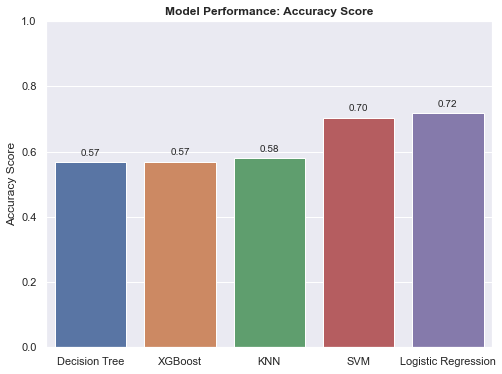

In [150]:
# Collate data
models = ['Logistic Regression', 'KNN', 'SVM', 'Decision Tree', 'XGBoost']
accuracies = np.array([lr_score, neigh_score, svc_score, dt_score, xgb_score])
accuracy = pd.DataFrame(data=accuracies, columns=['Accuracy Score'], index=models).sort_values(by='Accuracy Score')

plt.figure(figsize=(8, 6))
plt.title('Model Performance: Accuracy Score', fontweight='bold')
ax = sns.barplot(x=accuracy.index, y='Accuracy Score', data=accuracy)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

ax.set_ylim(0, 1);

### Logistic Regression: Performance statistics

Logistic regression achieves the following headline metrics:

- Accuracy: **72%**
- Specificity (TNR): **62%**
- Sensitivity (TPR): **80%**

There is however a trade-off between specificity and sensitivity that can be mapped for logistic regression: for example, sensitivity can be increased at the expense of specificity (and overall accuracy). This is because logistic regression, as a discriminative model, predicts probabilities, and then classifies based on probabilities compared to some cut-off value (by default, 0.5).

In this specific context, it would seem to be desirable to prioritise sensitivity to ensure those in ARD are correctly identified (by reducing the cut-off value from 0.5). 

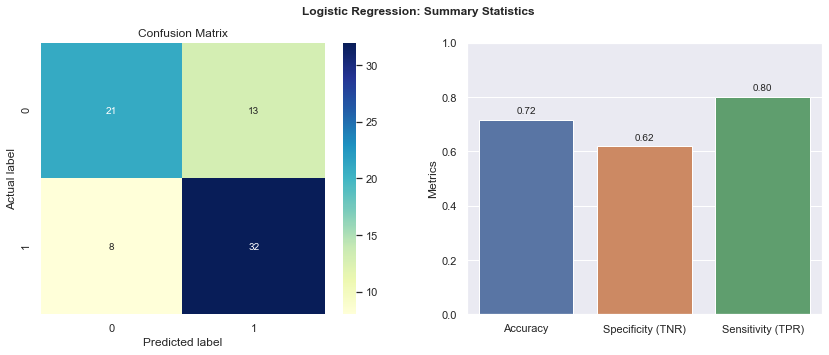

In [151]:
# Plot confusion matrix and summary statistics

conf = confusion_matrix(y, lr_pred)
acc = (conf[0][0] + conf[1][1]) / conf.sum() 
spec = conf[0][0] / conf[0].sum()
sens = conf[1][1] / conf[1].sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('Logistic Regression: Summary Statistics', fontweight='bold')

plot_conf_matrix(ax1, conf)

plot_bar_chart(ax2, xlabels=['Accuracy', 'Specificity (TNR)', 'Sensitivity (TPR)'], metrics=np.array([acc, spec, sens]), ylabel='Metrics')
ax2.set_ylim(0, 1);

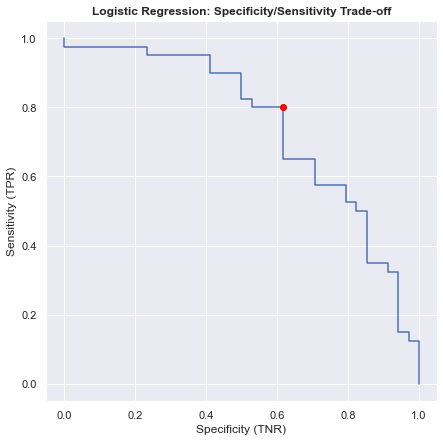

In [152]:
# Specificity vs. sensitivity

plot_spec_sens(lr_pred_prob[:,1], spec, sens, 'Logistic Regression: Specificity/Sensitivity Trade-off')

<a id='conclusions'></a>
## Conclusions & Next Steps

It is possible to predict whether a caller to NHS 111 is in ARD with a moderate degree of accuracy. Given the relatively limited data available, this can be seen as a positive result.

To improve model performance further, the dataset should be expanded in terms of number of calls (from the current 74), so that more features can be added to the model without suffering from the curse of dimensionality. These features could be:

- Additional feature engineering on the current data (e.g. incorporating operator metrics) 
- Information on the call content itself (e.g. a transcript or presence of certain key words)
- Phonetic analysis on the call using software similar to Praat (which has Python bindings through the Parselmouth library). Praat, for example, has been used to count the number of breaths in a recording. There might be issues here, however, with audio quality over the phone.  

Another open question is the extent to which only some initial percentage of the call can be used successfully for classification, since in production this model would ideally be used during a call - and not afterwards. 